In [46]:
%%bash
pip3 install gymnasium[classic_control]

In [47]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
device

device(type='cuda')

In [49]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [50]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class ModifiedDQNActivation(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ModifiedDQNActivation, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.LeakyReLU(self.layer1(x))
        x = F.LeakyReLU(self.layer2(x))
        return self.layer3(x)

    
class DeepDQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DeepDQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, n_actions)
        self.relu = nn.ReLU()  # You can replace ReLU with other activation functions like LeakyReLU, Tanh, etc.

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        return self.fc6(x)


Here are some hyperparameters you might consider tweaking and observing their effects on training:

Batch Size (BATCH_SIZE):

Try different batch sizes such as 32, 64, 128, etc.
Smaller batch sizes might introduce more noise but can help convergence in some cases.
Larger batch sizes might provide more stable updates but could slow down learning.

Discount Factor (GAMMA):

This parameter determines the importance of future rewards.
Try values closer to 1 for longer-term rewards and values closer to 0 for shorter-term rewards.
A too high or too low value could lead to unstable learning or slow convergence.

Exploration Rate (EPS_START, EPS_END, EPS_DECAY):

These parameters control the exploration-exploitation trade-off.
Adjusting these parameters affects how often the agent explores the environment versus exploiting its current knowledge.
Higher exploration rates encourage more exploration but may slow down convergence, while lower rates lead to more exploitation.

Target Network Update Rate (TAU):

This parameter controls how fast the target network tracks the policy network.
Higher values lead to faster updates but might introduce instability.
Lower values ensure a more stable target network but could slow down learning.

Learning Rate (LR):

The learning rate determines the step size during gradient descent.
Experiment with different learning rates to find a balance between convergence speed and stability.
Too high of a learning rate may cause oscillations or divergence, while too low may lead to slow convergence.

Replay Memory Capacity:

Adjust the capacity of the replay memory (e.g., 10000 in your case).
Larger capacities can store more experiences for learning but may require more memory.
Smaller capacities might cause the agent to forget useful experiences quickly.

Neural Network Architecture:

Experiment with the number of layers, units per layer, activation functions, etc., in your neural network.
Deeper networks might capture more complex relationships but could be prone to overfitting.
Simpler networks might generalize better but could underfit.

Optimizer and Loss Function:

You're using AdamW optimizer with Smooth L1 Loss (Huber Loss), which are common choices.
However, you can experiment with different optimizers like RMSprop, different loss functions, or even custom loss functions tailored to your problem.

Gradient Clipping:

You're already performing gradient clipping with torch.nn.utils.clip_grad_value_().
Experiment with different clipping thresholds to prevent exploding gradients.

In [51]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128

def batch_size_small():
    BATCH_SIZE = 32

GAMMA = 0.99

def gamma_decrease():
    GAMMA = 0.75
    
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

def change_ModifiedDQNActivation():
    policy_net = ModifiedDQNActivation(n_observations, n_actions).to(device)
    target_net = ModifiedDQNActivation(n_observations, n_actions).to(device)
    
def change_DeepDQN():
    policy_net = DeepDQN(n_observations, n_actions).to(device)
    target_net = DeepDQN(n_observations, n_actions).to(device)
    
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

def memory_increase():
    memory = ReplayMemory(50000)
    
def memory_decrease():
    memory = ReplayMemory(2500)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In the provided code, there are two lines plotted on the same graph:

Blue Line: This line represents the duration of each episode during training. It shows how many steps the agent was able to keep the pole balanced before the episode ended (either due to the pole falling or reaching a maximum episode length).

Orange Line: This line represents the moving average of episode durations. It calculates the average duration of the last 100 episodes at each point in training. This moving average is useful for smoothing out fluctuations and providing a clearer trend of the agent's learning progress over time.

Here's a breakdown of what each line signifies:

Blue Line (Episode Duration):

Each data point on this line corresponds to the duration of a single episode during training.
It gives a direct measure of the agent's performance in terms of how long it can balance the pole before it falls.
Fluctuations or trends in this line indicate changes in the agent's behavior or learning progress over episodes.
Orange Line (Moving Average):

This line represents the average duration of the last 100 episodes at each point in training.
It provides a smoothed-out view of the agent's performance over time, helping to identify long-term trends.
The moving average helps in understanding the overall learning progress of the agent, filtering out short-term fluctuations.
Together, these lines provide valuable insights into the training process of the DQN agent. The blue line gives a detailed view of episode durations, while the orange line offers a more stable representation of the agent's learning trend over time.

In [52]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [53]:
import time

In [54]:
 def main_func():
    global episode_durations
    if torch.cuda.is_available():
        num_episodes = 600 # 600
    else:
        num_episodes = 50

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break

    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()
    
    episode_durations = []

In [55]:
start_time = time.time()
main_func()

print("Time Taken")
print(time.time() - start_time)

In [56]:
# batch_size_small()
# start_time = time.time()
# main_func()

# print("Time Taken")
# print(time.time() - start_time)

In [57]:
# gamma_decrease()
# start_time = time.time()
# main_func()

# print("Time Taken")
# print(time.time() - start_time)

In [58]:
# memory_increase()
# start_time = time.time()
# main_func()

# print("Time Taken")
# print(time.time() - start_time)

In [59]:
# memory_decrease()
# start_time = time.time()
# main_func()

# print("Time Taken")
# print(time.time() - start_time)

Complete


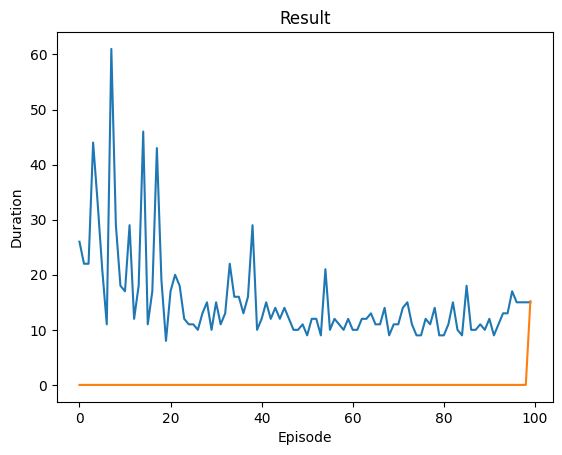

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Time Taken
30.673184633255005


In [60]:
# change_ModifiedDQNActivation()
# start_time = time.time()
# main_func()

# print("Time Taken")
# print(time.time() - start_time)